[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/comp-neural-circuits/plasticity-workshop/blob/dev/rate_based.ipynb)

# Rate-based Plasticity Rules

## Hebbian Plasticity

**Goals**
+ Covariance-based learning rule is equivalent to detecting the first principal component of the activity


### Initialization

In [1]:
!pip install numpy scipy matplotlib ipywidgets scikit-learn panel --quiet
import numpy as np
import scipy.linalg as lin
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# for the PCA
from sklearn.decomposition import PCA
plt.style.use("https://github.com/comp-neural-circuits/plasticity-workshop/raw/dev/plots_style.txt")#
#plt.style.use("plots_style.txt")

### Utility Functions

In [2]:
def ornstein_uhlenbeck(mean,cov,dt,Ttot,dts=1E-2):
    """
    Generates a multi-dimensional Ornstein-Uhlenbeck process.

    Parameters :
    mean (numpy vector) : desired mean
    cov  (matrix)   : covariance matrix (symmetric, positive definite)
    dt   (real)     : timestep output
    Tot  (real)     : total time
    dts = 1E-3 (real) : simulation timestep

    Returns :
    times (numpy vector)
    rates (numpy matrix)  :  rates[i,j] is the rate of unit i at time times[j]
    """
    times = np.arange(0.0,Ttot,dt)
    n = len(mean)
    nTs = int(Ttot/dts)
    rates_all = np.empty((n,nTs))
    rates_all[:,0] = mean
    L = lin.cholesky(cov)
    nskip = int(dt/dts)
    assert round(dts*nskip,5) == dt , "dt must be multiple of  " + str(dts)
    for t in range(1,nTs):
        dr = dts*(mean-rates_all[:,t-1])
        dpsi = np.sqrt(2*dts)*(L.T @ rng.standard_normal(n))
        rates_all[:,t] = rates_all[:,t-1] + dr + dpsi
    # subsample 
    rates = rates_all[:,::nskip]
    return times,rates
  
def twodimensional_OU(mean1,var1,mean2,var2,corr,dt,Ttot,dts=1E-2):
    """
    Generates samples from a 2D Ornstein-Uhlenbeck process.

    Parameters :
    mean1 (real) : mean on first dimension
    var1  (real) : variance on first dimension (at dt=1. intervals)
    mean2 (real) : - 
    var2  (real) : - 
    corr  (real) : correlation coefficient 
    dt   (real)     : timestep output
    Tot  (real)     : total time
    dts = 1E-3 (real) : simulation timestep

    Returns :
    times  (numpy vector)
    rates1 (numpy vector)
    rates2 (numpy vector)
    """
    assert -1<corr<1, "correlation must be in (-1,1) interval"
    var12 = corr*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    (times, rates) = ornstein_uhlenbeck(
      np.array([mean1,mean2]),
      cov_mat,
      dt,Ttot,dts)
    return times, rates #rates[0,:],rates[1,:]


def plot_r1_and_r2(correlation=0.0,mean_r1=0.0,mean_r2=0.0,var_r1=1.0,var_r2=1.0):
    times,rates = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,0.1,60.0)
    rates1 = rates[0,:]
    rates2 = rates[1,:]
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10)) #gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(times,rates1)
    ax1.plot(times,rates2)
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("rate (Hz)")
    ax1.set_title("time traces")
    ax2.scatter(rates1,rates2,color="black")
    ax2.set_title("samples r1 Vs r2")
    ax2.set_xlabel("rate 1 (Hz)")
    ax2.set_ylabel("rate 2 (Hz)")
    ax2.axis("equal")
    return 

def analytic_correlation_based(r_means,r_cov,times,weights_start,gamma):
    """
    Computes the analytic solution for the correlation-based
    plasticity rule. Assuming the input is a multi dimensional 
    O-U process.
    
    Parameters :
    r_means (vector) : input means
    r_cov   (matrix) : input covariance matrix
    times   (vector) : time vector
    weights_start (vector) : initial conditions for weights
    gamma   (number) : learning coefficient
    
    Returns :
    weights (matrix) : weights[i,k] is the weight from neuron i at time times[k]
    """
    Ntimes = len(times)
    N = len(r_means)
    weights = np.empty((N,Ntimes))
    M = gamma*(r_cov + np.outer(r_means,r_means)) + np.identity(N)
    for k in range(Ntimes):
        weights[:,k] = np.linalg.matrix_power(M,k) @ weights_start
    return weights

def analytic_covariance_based(r_means,r_cov,times,weights_start,gamma):
    """
    Computes the analytic solution for the covariance-based
    plasticity rule. Assuming the input is a multi dimensional 
    O-U process.
    
    Parameters :
    r_means (vector) : input means
    r_cov   (matrix) : input covariance matrix
    times   (vector) : time vector
    weights_start (vector) : initial conditions for weights
    gamma   (number) : learning coefficient 
    
    Returns :
    weights (matrix) : weights[i,k] is the weight from neuron i at time times[k]
    """
    Ntimes = len(times)
    N = len(r_means)
    weights = np.empty((N,Ntimes))
    M = gamma*r_cov + np.identity(N)
    for k in range(Ntimes):
        weights[:,k] = np.linalg.matrix_power(M,k) @ weights_start
    return weights



def test_weight_update_correlation():
    # numeric result
    mean_r1,var1 = 3.0,0.3
    mean_r2,var2 = 5.0, 0.2
    correlation = 0.7
    T = 100.0
    gamma = 1.0
    weights = rng.random(2) + 5.0
    times,rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,0.2,T)
    weight_update = weight_update_correlation(rates_input,weights,gamma)
    
    # analytic result
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_correlation_based(r_means,cov_mat,np.array([0,T]),weights,gamma)[:,1]
    weight_update_an = weights_an - weights
    print(f"expected (approx): {weight_update_an} \t function output {weight_update}") 
    if all(np.isclose(weight_update,weight_update_an,rtol=0.3)):
        print("**** test PASSED ! ****")
    else:
        print("**** test FAILED ! ****")
    return
 
def test_weight_update_covariance():
    # numeric result
    mean_r1,var1 = 3.0,0.3
    mean_r2,var2 = 5.0, 0.2
    correlation = 0.7
    T = 100.0
    gamma = 1.0
    weights = rng.random(2) + 5.0
    times,rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,0.2,T)
    weight_update = weight_update_covariance(rates_input,weights,gamma)
    
    # analytic result
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_covariance_based(r_means,cov_mat,np.array([0,T]),weights,gamma)[:,1]
    weight_update_an = weights_an - weights
    print(f"expected (approx): {weight_update_an} \t function output {weight_update}") 
    if all(np.isclose(weight_update,weight_update_an,rtol=0.3)):
        print("**** test PASSED ! ****")
    else:
        print("**** test FAILED ! ****")

        
def weight_evolution_correlation(mean_r1,var1,mean_r2,var2,correlation,
                                 weights_start,Tstep=100.0,Nsteps=20,gammahat=1E-3,dtsample=0.2):
    weight_ret = np.empty(Nsteps)
    times_ret = np.arange(0.0,Tstep*Nsteps,Tstep)
    gamma = gammahat*Tstep
    weights_temp = np.copy(weights_start)
    for k in range(Nsteps):
        weight_ret[k]=weights_temp[0]
        _times,_rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,dtsample,Tstep)
        _weight_updates = weight_update_correlation(_rates_input,weights_temp,gamma)
        weights_temp += _weight_updates
    
    # analytic solution
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_correlation_based(r_means,cov_mat,times_ret,weights_start,gamma)
        
    return times_ret,weight_ret,weights_an[0,:]

def weight_evolution_covariance(mean_r1,var1,mean_r2,var2,correlation,
                                weights_start,Tstep=100.0,Nsteps=20,gammahat=1E-3,dtsample=0.2):
    weight_ret = np.empty(Nsteps)
    times_ret = np.arange(0.0,Tstep*Nsteps,Tstep)
    gamma = gammahat*Tstep
    weights_temp = np.copy(weights_start)
    for k in range(Nsteps):
        weight_ret[k]=weights_temp[0]
        _times,_rates_input = twodimensional_OU(mean_r1,var1,mean_r2,var2,correlation,dtsample,Tstep)
        weight_updates = weight_update_covariance(_rates_input,weights_temp,gamma)
        weights_temp += weight_updates
    
    # analytic solution
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    r_means = np.array([mean_r1,mean_r2])
    weights_an = analytic_covariance_based(r_means,cov_mat,times_ret,weights_start,gamma)
        
    return times_ret,weight_ret,weights_an[0,:]

def weight_evo_all(mean_r1,var1,mean_r2,var2,correlation,):
    weights_start = np.array([1E-2,1E-2])
    times,wcorr,wcorran = weight_evolution_correlation(mean_r1,var1,mean_r2,\
                                                       var2,correlation,weights_start)
    _,wcov,wcovan = weight_evolution_covariance(mean_r1,var1,mean_r2,\
                                                       var2,correlation,weights_start)
    times += times[1]-times[0] # time starts from value >0 , so I can plot in log-log scale
    fig,ax = plt.subplots()
    linecorr, = ax.plot(times,wcorr,color="xkcd:ocean blue",label="correlation-based")
    # plt.plot(times,wcorran,'--',color="xkcd:ocean blue",alpha=0.8)
    
    linecov, = ax.plot(times,wcov,color="xkcd:blood red",label="covariance-based")
    # plt.plot(times,wcovan,'--',color="xkcd:blood red",alpha=0.8)
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('synaptic weight')
    ax.legend(handles=[linecorr,linecov])
    return 

#### PCA PART ###

def first_principal_component(x):
    """
    Computes the first principal component from x
    
    Parameters:
    x (matrix) :  x[k,i] is the value of the i component of x at time t[k]
    
    Returns :
    pca1 (vector) : vector of norm 1 that captures the direction of maximum variability
    """
    pca = PCA(n_components=1)
    pca.fit(x)
    return pca.components_[0,:]


def plot_r1_and_r2_with_PCA(mean_r1=0.0,mean_r2=0.0,var_r1=1.0,var_r2=1.0,correlation=0.6,):
    times,rates_input = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,0.1,60.0)
    rates1 = rates_input[0,:]
    rates2 = rates_input[1,:]
    pcavec = first_principal_component(rates_input.T)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,10)) #gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(times,rates1)
    ax1.plot(times,rates2)
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("rate (Hz)")
    ax1.set_title("time traces")
    
    ax2.scatter(rates1,rates2,color="black")
    ax2.set_title("samples r1 Vs r2")
    ax2.set_xlabel("rate 1 (Hz)")
    ax2.set_ylabel("rate 2 (Hz)")
    ax2.axis("equal")
    xmin,xmax = ax2.get_xlim()
    ymin,ymax = ax2.get_ylim()
    xpca_plot = np.array([-pcavec[0]*100,pcavec[0]*100])+mean_r1
    ypca_plot = np.array([-pcavec[1]*100,pcavec[1]*100])+mean_r2
    ax2.plot(xpca_plot,ypca_plot,"--",color="red")
    ax2.set_xlim((xmin,xmax))
    ax2.set_ylim((ymin,ymax))
    return

def plot_covrule_and_PCA(mean_r1=0.0,mean_r2=0.0,var_r1=1.0,var_r2=1.0,correlation=0.6):
    gammahat=1E-3
    Tstep=100.
    Nsteps=20
    dtsample=1.0
    times,rates_input = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,0.2,100.0)
    pcavec = first_principal_component(rates_input.T)
    
    # now, covariance rule
    weights_start = np.array([1E-1,1E-1])
    gamma = gammahat*Tstep
    weights_end = np.copy(weights_start)
    for k in range(Nsteps):
        _times,_rates_input = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,dtsample,Tstep)
        _weight_updates = weight_update_covariance(_rates_input,weights_end,gamma)
        weights_end += _weight_updates
    
    fig,ax= plt.subplots()
    weights_end = weights_end / lin.norm(weights_end) 
    
    
    ax.scatter(rates1,rates2,color="black")
    ax.set_xlabel("rate 1 (Hz)")
    ax.set_ylabel("rate 2 (Hz)")
    ax.axis("equal")
    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    xpca_plot = np.array([-pcavec[0]*100,pcavec[0]*100])+mean_r1
    ypca_plot = np.array([-pcavec[1]*100,pcavec[1]*100])+mean_r2
    linepca,=ax.plot(xpca_plot,ypca_plot,"--",color="red",label="1st principal component ")
    
    xw_plot = np.array([-weights_end[0]*100,weights_end[0]*100])+mean_r1
    yw_plot = np.array([-weights_end[1]*100,weights_end[1]*100])+mean_r2
    lineweights,=ax.plot(xw_plot,yw_plot,"--",color="blue",label="weights after learning")
    
    ax.set_xlim((xmin,xmax))
    ax.set_ylim((ymin,ymax))
    
    ax.legend(handles=[linepca,lineweights])
    return
    

### Visualize noisy rate inputs

In this tutorial we generate a noisy rate trace from $N$ neurons. $r_j(t)$ indicates the rate of neuron $j=1,2,\ldots\,N$ at time $t$. Neurons are, in general, correlated with each other.

In the figure below, you can see the traces of 2 neurons, simulated for 60 seconds. You don't need to read or understand this code. Try to modify some of the parameters to understand their behavior.

In [3]:
interact(plot_r1_and_r2,correlation=(-0.99,0.99,0.01) , mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,2.0,0.01), var_r2=(0.01,2.0,0.01));


interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Float…

If you have extra time, check the documentation of the functions `ornstein_uhlenbeck(...)` and `twodimensional_OU(...)`, which are used to generate these traces.

### Exercise 1 . Compute response of output neuron based on input activity and weights

$$
r_\text{out}(t) = \sum_{j=1}^N w_j r_j(t)
$$

In [4]:
# EXERCISE
def rate_response(r_input,weights):
    """
    Computes the response of a neuron that receives a series of inputs over time.  
    
    Parameters :
    r_input (matrix) :  r_input[i,t] is the rate of input neuron i at timestep t
    weights (vector) :  weights[i] is the synaptic strenght between neuron i and the output neuron
    
    Returns :
    r_output (vector) : r_output[t] is the rate of the output neuron at timestep t
    """
    
    # I think this can be done with np.dot , but I don't like to see it applied to matrices
    # so I propose a more canonical broadcasting
    
    r_input_weighted = r_input * weights[:,np.newaxis] # multiply columnwise
    r_output = r_input_weighted.sum(axis=0) # and sum columnwise
    # r_output[r_output < 0 ] = 0  # avoid negative rates
    return r_output

### Compute weight update for correlation based and covariance based rule

Now that you have the reponse of the output neuron  $r_\text{out}(t)$ , you can calculate the update in synaptic weights due to rate-based plasticiy.

#### Some notation
We use $\left< \; \ldots \; \right>_t$ to indicate an average over time. For mean rates, we further simplify the notation, taking the form $ \bar{r}_j$. Therefore:
$$
\bar{r}_j = \left< r_j(t) \right>_t = 
\frac1T \int_0^T r_j(t) \;\mathrm d t = 
\frac{1}{N_T} \sum_k  r_j(t_k)
$$
The last equality represents the fact that $r(t)$ is discretized in our code, and $N_T$ indicates the number of discretized steps.


#### Correlation-based rule
The correlation-based rule is defined as :
$$ 
\Delta w_j = \gamma \; \left<  r_\text{out}(t) \; r_j(t)  \right>_t
$$

The second moment can be computed numerically simply as the mean of the element-wise product between the two time series.
$$
\left<  r_\text{out}(t) \; r_j(t)  \right>_t = \frac{1}{N_T}\sum_k  r_\text{out}(t_k) \; r_j(t_k) 
$$


----
*Technical note:*  
the weight update rate should really be $\gamma=\hat{\gamma}\;T$, where $\hat{\gamma}$ is the weight update *per second*.  
Consider also dimensional analysis: if $\text{rate}\sim \text{time}^{-1}$, then it must be $\gamma \sim \text{time}\times \text{weight}$.  

---

In [5]:
# EXERCISE
def weight_update_correlation(r_input,weights,gamma):
    """
    Computes the weight updates according to the correlation rule
    
    Parameters :
    r_input (matrix) : r_input[i,t] is the rate of input neuron i at timestep t
    weights (vector) : weights[i] is the synaptic strenght between neuron i and the output neuron
    gamma   (number) : plasticity parameter
    T       (number) : total simulation time, in seconds
    
    Returns :
    weight_updates (vector) : the update on each weight after this training interval
    """

    # TIPS : 
    # use the rate_response function that you defined before !
   
    r_output = rate_response(r_input,weights)
    r_product  = r_output * r_input  # broadcast by row
    weight_updates = gamma * r_product.mean(axis=1) # average over time dimension
    return weight_updates

### Validate the exercise

To test your function, run the cell below. It should return `test PASSED !` if it errors, or returns `test FAILED !` please review your solution before you proceed.


In [6]:
# TESTING
test_weight_update_correlation()   

expected (approx): [128.20327555 211.52486139] 	 function output [117.12653595 200.7566447 ]
**** test PASSED ! ****


#### Covariance based rule
In the covariance-based rule, we are using a covariance, instead :

$$ 
\Delta w_j = \gamma \; \left<  \left(r_\text{out}(t) - \bar{r}_\text{out}\right)
\; \left(r_j(t) - \bar{r}_j \right)  \right>_t \quad \text{with} \quad 
\bar{r}_\text{out} = \left< r_\text{out}(t) \right>_t \quad \text{and} \quad
\bar{r}_j = \left< r_j(t) \right>_t
$$

To compute this quantity numerically, simply subtract the means from the rate traces, and then proceed as in the previous case.

In [7]:
# EXERCISE
def weight_update_covariance(r_input,weights,gamma):
    """
    Computes the weight updates according to the covariance rule
    
    Parameters :
    r_input (matrix) :  r_input[i,t] is the rate of input neuron i at timestep t
    weights (vector) :  weights[i] is the synaptic strenght between neuron i and the output neuron
    
    Returns :
    weight_updates (vector) : the update on each weight after this training interval
    """
    
    # TIPS : 
    # it is very similar to the correlation rule, except you need to subtract the mean rates!
    # r_input_means = r_input.mean(axis=1)  # (mean over time axis)
    r_output = rate_response(r_input,weights)
    r_output_mean = r_output.mean() # mean of a vector -> scalar value
    r_output_meanzero = r_output - r_output_mean
    r_input_means = r_input.mean(axis=1) # mean over time axis
    r_input_meanzero = r_input - r_input_means[:,np.newaxis] # broadcast on columns
    # now same as before
    r_product = r_output_meanzero * r_input_meanzero # elementwise product
    weight_updates = gamma * r_product.mean(axis=1) # mean over time
    return weight_updates

### Validate the exercise

As before, to test your function, run the cell below. It should return `test PASSED !` if it errors, or returns `test FAILED !` please review your solution before you proceed.

In [8]:
# TEST 
test_weight_update_covariance()

expected (approx): [2.56642245 2.00995546] 	 function output [2.53656016 2.10519688]
**** test PASSED ! ****


### Visualize $w(t)$ for covariance vs correlation rule

Here we show how how one synaptic weight would change over time, according to the two rules. This system has two input neurons and one output neuron. For simplicity we only show the first weights.

The code simulates rate activity for $t=100\; \text{s}$, keeping weights stationary, and then updates the weights based on the correlation/covariance computed in that interval. This is repeated several times so that we can observe the change of weight over time.

The weight is not stable, and tends to reach very high values, therefore we show it using a logarithmic scale.

In [9]:
interact_manual(weight_evo_all, mean_r1=(0.0,5.0,0.1),var1=(0.01,2.0,0.01),
         mean_r2=(0.0,5.0,0.1),var2=(0.01,2.0,0.01) , correlation=(-0.99,0.99,0.01));


interactive(children=(FloatSlider(value=2.5, description='mean_r1', max=5.0), FloatSlider(value=1.0, descripti…

### Questions

+ Which rule results in a faster growth of the weight, and why ?
+ Which factor is determining the higher growth ?
+ When do the two rules coincide, and why is that ? 

## The covariance rule corresponds to the first principal component of the input rates

Let's consider again the time-traces of two input neurons, $r_1(t)$ and $r_2(t)$. This time focus on the second plot: it shows samples of the two activities over time.

The **first principal component**, in red, represents the direction where most of the variance lies. 

Here we use `scikit-learn` to compute it: 
```python
r_input = ... <generate neural activity>

from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(r_input)
first_component = pca.components_[0,:]
```
Warning ! For the scikit-learn fit we need the format `r_input[k,i]`, where `k` represents time `t[k]` and `i` is the neuron.

Change the parameters and see how the PCA follows the scatter plot accordingly.

In [10]:
interact(plot_r1_and_r2_with_PCA,correlation=(-0.99,0.99,0.01) , mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,2.0,0.01), var_r2=(0.01,2.0,0.01));

interactive(children=(FloatSlider(value=0.0, description='mean_r1', max=5.0), FloatSlider(value=0.0, descripti…

Now we compare the direction of the PCA with the normalized weights $(w_1,w_2)$ after learning with the covariance rule. The two lines coincide.

In [11]:

interact_manual(plot_covrule_and_PCA,correlation=(-0.99,0.99,0.01) , mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,2.0,0.01), var_r2=(0.01,2.0,0.01));


interactive(children=(FloatSlider(value=0.0, description='mean_r1', max=5.0), FloatSlider(value=0.0, descripti…

## Bounded plasticity
In this section, we modify the plasticity rule, so that synaptic weights do not diverge to $+\infty$ exponentially. We denote the covariance matrix of the input rates as $C$. Therefore :
$$
C_{ij} := \left<  \left(r_i(t) - \bar{r}_i\right)
\; \left(r_j(t) - \bar{r}_j \right)  \right>_t
$$

We consider two types of normalization, defined in vector form:

**Subtractive normalization**
$$
\Delta \mathbf w = \gamma \; \left(  C \, \mathbf w -
\frac{\boldsymbol{1}^\top \,C \,\mathbf{w}}{N} \boldsymbol{1}  \right)
\;\; \text{where}\;\; \mathbf w = (w_1,w_2,\ldots w_N)
\;\; \text{and}\;\; \boldsymbol{1} = (1,1\ldots 1)  \;\;\text{$N$ times}
$$
**Divisive normalization**
$$
\Delta \mathbf w = \gamma \; \left(  C \, \mathbf w -
\frac{\boldsymbol{1}^\top \,C \,\mathbf{w}}{ \boldsymbol{1}^\top \,\mathbf{w}}
\mathbf{w}  \right)
\;\; \text{where}\;\; \mathbf w = (w_1,w_2,\ldots w_N)
\;\; \text{and}\;\; \boldsymbol{1} = (1,1\ldots 1)  \;\;\text{$N$ times}
$$

The last exercise consists in writing the weight update function for these two new rules. 

In [12]:
# EXERCISE
def weigth_update_bounded_subtractive(cov_mat,weights,gamma):
    """
    Covariance-based weight update with subtractive normalization 
    """
    N = len(weights)
    onevec = np.ones(N)
    cov_times_w = cov_mat @ weights
    return gamma * ( cov_times_w - cov_times_w.mean())


In [49]:
# EXERCISE
def weigth_update_bounded_divisive(cov_mat,weights,gamma):
    """
    Covariance-based weight update with divisive normalization 
    """
    N = len(weights)
    onevec = np.ones(N)
    cov_times_w = cov_mat @ weights
    wsum = weights.sum()
    if wsum == 0:
        return 0.0
    else:
        retpiece = (cov_times_w.sum()/wsum) * weights
        retval = gamma * ( cov_times_w - (cov_times_w.sum()/wsum) * weights )
        return retval


In [14]:
# *** TO DO ***** 
# test the functions !

 The next exercise is to complete the missing parts in the training function. The algorithm does the following:
   1. start with some initial synaptic weights 
   1. simulate input neural rates for 60 seconds
   1. compute the covariance matrix
   1. update the weights
   1. go back to point 2, until convergence (e.g. a sufficiently long time)
  

In [15]:
def train_weights_bounded(mean_r1,var_r1,mean_r2,var_r2,correlation,
                          w1_start,w2_start,
                          wmin = 0.0, wmax = 1.0,
                          do_subtractive=True,
                          Tcycle=60.0,Ncycles=100,gammahat=1E-3):
    
    N = 2
    
    # select which normalization takes place
    # (E) : complete with function names
    if do_subtractive:
        weight_update_fun = weigth_update_bounded_subtractive
    else:
        weight_update_fun = weigth_update_bounded_divisive
    
    # these are the times at which the weights are updated
    times_ret = np.arange(0,Tcycle*Ncycles,Tcycle)
    
    # (E) initialize small weights. Use np.random.rand(...) to generate random values    
    weights = np.empty((N,Ncycles))
    weights[:,0] = np.array([w1_start,w2_start]) 
    
    # Do several 60 second cycles
    gamma = gammahat * Tcycle
    for k in range(Ncycles-1):
        _time,_rate_inputs = twodimensional_OU(mean_r1,var_r1,mean_r2,var_r2,correlation,1.0,Tcycle)
        # (E) compute the covariance matrix of the input rates
        # using np.cov
        # then update the weights using the functions defined before
        _cov_mat = np.cov(_rate_inputs)
        wtemp =  weights[:,k] + weight_update_fun(_cov_mat,weights[:,k],gamma)
        wtemp[wtemp<wmin] = wmin
        wtemp[wtemp>wmax] = wmax
        weights[:,k+1] = wtemp
    
    return times_ret, weights

 

In [16]:
times,weights = train_weights_bounded( 1.,0.5,4.,0.5,0.0,
                                      0.4,0.8,
                                      do_subtractive=False,
                                    Tcycle=60.0,Ncycles=100)
                                      

(0.3649288299828636, 0.414927907167653, 0.7850720928323469, 0.8350711700171366)

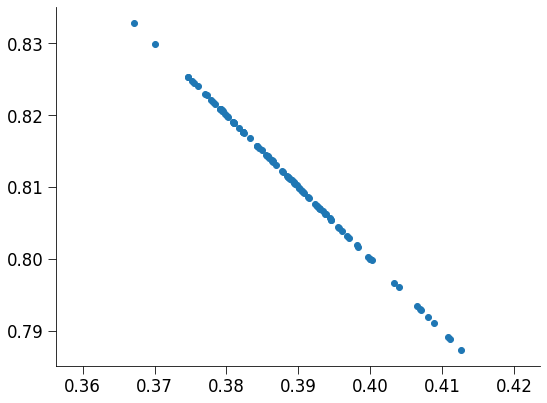

In [17]:
fig,ax = plt.subplots()
ax.scatter(weights[0,:],weights[1,:])
ax.axis("equal")

In [18]:
def train_weights_vector_field_direction(
                          var1,var2,correlation,
                          weights,gamma,
                          wmin = 0.0, wmax = 1.0,
                          do_subtractive=True):
    
    if do_subtractive:
        weight_update_fun = weigth_update_bounded_subtractive
    else:
        weight_update_fun = weigth_update_bounded_divisive
    # analytic, for speed
    var12 = correlation*np.sqrt(var1*var2)
    cov_mat = np.array([[var1,var12],[var12,var2]])
    deltaw = weight_update_fun(cov_mat,weights,gamma)
    new_weights = weights + deltaw
    new_weights[new_weights<wmin] = wmin
    new_weights[new_weights>wmax] = wmax
    return new_weights - weights

    


In [62]:
def train_weights_bounded_plot(mean_r1=1.0,mean_r2=3.0,var_r1=1.0,var_r2=1.001,correlation=0.0,
                          w1_start=0.3,w2_start=0.5,
                          do_subtractive=True):
    wmin,wmax = 0.0,1.0
    Tcycle = 60.0
    Ncycles = 200
    gammahat=1E-3
    times,weights = train_weights_bounded(
                          mean_r1,var_r1,mean_r2,var_r2,correlation,
                          w1_start,w2_start,
                          wmin = wmin, wmax = wmax,
                          do_subtractive=do_subtractive,
                          Tcycle=Tcycle,Ncycles=Ncycles,gammahat=gammahat)
    
    fig,ax = plt.subplots(figsize=(10,10))
    ax.scatter(weights[0,:],weights[1,:])
    ax.axis("equal")
    ax.set_xlim((wmin-0.05,wmax*1.05))
    ax.set_ylim((wmin-0.05,wmax*1.05))
    # now the background
    x = np.arange(wmin,wmax*1.01,0.1)
    y = np.copy(x)
    nw = len(x)

    X,Y = np.meshgrid(x,y)

    XY = np.stack([X,Y],axis=2)
    VXY = np.empty_like(XY)
    gamma = gammahat*Tcycle
    weights_direction = lambda w : train_weights_vector_field_direction(
                          var_r1,var_r2,correlation,
                          w,gamma,
                          wmin = wmin, wmax = wmax,
                          do_subtractive = do_subtractive)


    for ix in range(nw):
        for iy in range(nw):
            VXY[ix,iy,:] = weights_direction(XY[ix,iy,:])
    Vx = VXY[:,:,0]
    Vy = VXY[:,:,1]
    ax.quiver(X,Y,Vx,Vy, linewidth=None, color="black")
    return 


In [63]:

interact_manual(train_weights_bounded_plot,mean_r1=(0.0,5.0,0.1),mean_r2=(0.0,5.0,0.1),
        var_r1=(0.01,2.0,0.01), var_r2=(0.01,2.0,0.01),correlation=(-0.99,0.99,0.01),
        w1_start = (0.01,1.0,0.01) ,w2_start = (0.01,1.0,0.01)   );

interactive(children=(FloatSlider(value=1.0, description='mean_r1', max=5.0), FloatSlider(value=3.0, descripti…

In [45]:
if 0.0 == 0:
    print("is zero")

is zero
